# CNN

## 1. Imports

### 1.1 Setup for Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


In [3]:
ls

CNN_Final.ipynb                  NewDataImages/  Thermal/
Correct_CNN_RGB_Final.ipynb      RGB/            ThermalAug/
Correct_CNN_THERMAL_Final.ipynb  RgbAug/         trainingResults/


### 1.2 Install Depedencies

In [ ]:
#install dependencies
# !pip install -r requirements.txt

In [4]:
import os
import copy
import glob
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms,models
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import pandas as pd
import wandb
import time
from datetime import datetime

### 1.2 Global Variables

In [5]:
EPOCHS = 30
CLASSES = 7
BATCH_SIZE = 64
NUM_WORKERS = 12 # change based on specification of computer
LEARNING_RATE = 0.001

## 2. Load Data and Split

In [6]:
#directories
rgbDir = ['RGB','RgbAug']
thermalDir = ['Thermal','ThermalAug']

### 2.1 Single Modality

In [8]:
def loadDataSingleModality(modalDir):
    '''
    Loads and processes data from a single modality (either RGB or Thermal).
    Args:
        modalDir (list): List containing two directory paths - first for raw images, second for augmented images.
    Returns:
        pairedFiles (list): List of all image file paths.
        tensorLabels (torch.Tensor): Tensor of integer-encoded labels corresponding to the images.
    '''

    #get list of files in the directory and combine them
    pairedFiles = []
    for data in modalDir:
        pairedFiles.extend(glob.glob(os.path.join(data, "*")))
    pairedFiles = sorted(pairedFiles)

    print(f'Total files: {len(pairedFiles)}')


    #get the labels from the filenames
    SMLabels = [os.path.basename(f).split('_')[1] for f in pairedFiles] #1 = emotion label

    #convert labels to integer
    le = preprocessing.LabelEncoder()
    intLabels = le.fit_transform(SMLabels)
    #convert targets to tensor
    tensorLabels = torch.as_tensor(intLabels)
    #class names
    classNames = le.classes_

    print(f'Data arranged as: {tensorLabels}')
    print(f'\nSample output:\nFile: {pairedFiles[0]}\nLabel: {SMLabels[0]}\n')

    return pairedFiles, tensorLabels, classNames


## For single modality testing (uaing raw and augmented data together)

#change this to test either thermal or rgb
modalDir = thermalDir

#Call function to load data
pairedFiles, tensorLabels, classNames = loadDataSingleModality(modalDir)

#for saving results later
if modalDir == rgbDir:
    savingLabel = "RGB"
else:
    savingLabel = "Thermal"

Total files: 20695
Data arranged as: tensor([0, 0, 0,  ..., 6, 6, 6])

Sample output:
File: Thermal/T_Angry_10_KTFE.jpg
Label: Angry



### 2.3 Split Data
- 80:20

In [9]:

#Split Data
X_train, X_test, y_train, y_test = train_test_split(
    pairedFiles, tensorLabels,
    test_size=0.2,
    stratify=tensorLabels,
    random_state=42
)
print(f'Train size: {len(X_train)}\nTest size: {len(X_test)}')

Train size: 16556
Test size: 4139


In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## 3. DataLoader

### 3.1 Single Modality

In [11]:
class SingleModalImageDataset(Dataset):
    def __init__(self, pairedFiles, labels, transform=None):
        #initialise
        self.pairedFiles = pairedFiles
        self.labels = labels
        self.transform = transform

    def __len__(self):
        #return the length of the dataset
        return len(self.pairedFiles)

    def __getitem__(self, idx):
        #generates samples
        imagePath = self.pairedFiles[idx]
        image = Image.open(imagePath).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


train_dataset = SingleModalImageDataset(X_train, y_train, transform=transform)
test_dataset = SingleModalImageDataset(X_test, y_test, transform=transform)

### 3.3 Train and Test Loader

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 4. ShuffleNet V.2

### 4.1 Single Modality

In [14]:
# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"

#initialise model
model = models.shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, CLASSES)
model.to(device)

#loss function and optimiser
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

# To collect data for plotting later
trainLosses = []
testAccuracies = []


# Training timing setup
print("Starting training...")
training_start_time = time.time()
training_start_datetime = datetime.now()
print(f"Training started at: {training_start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")

# Training loop
for epoch in range(EPOCHS):
    model.train()
    runningTrain = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        x, y = x.to(device), y.to(device)
        optimiser.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimiser.step()
        runningTrain += loss.item() * x.size(0)

    trainLoss = runningTrain / len(train_loader.dataset)

    model.eval()
    accPre = 0
    totalDatapoints = 0
    predictionsArr, targetsArr = [], []

    for x, target in tqdm(test_loader, desc=f"Epoch {epoch+1} Evaluating"):
        x, target = x.to(device), target.to(device)
        with torch.no_grad():
            outputs = model(x)
            predicted = outputs.argmax(1)

            predictionsArr.extend(predicted.cpu().numpy())
            targetsArr.extend(target.cpu().numpy())

            accPre += (predicted == target).sum().item()
            totalDatapoints += target.size(0)

    finalAcc = accPre / totalDatapoints
    trainLosses.append(trainLoss)
    testAccuracies.append(finalAcc)

    print(f"Epoch {epoch+1}: Train Loss = {trainLoss:.4f}, Test Accuracy = {finalAcc:.4f}")


# Training completion timing
training_end_time = time.time()
training_end_datetime = datetime.now()
total_training_time = training_end_time - training_start_time

# Final results
print(f"\nTraining completed..")
print(f"Training started at:  {training_start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training ended at:    {training_end_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total training time:  {total_training_time/3600:.2f} hours ({total_training_time/60:.2f} minutes)")
print(f"Best Test Accuracy: {max(testAccuracies):.4f}")
print(f"Final Test Accuracy: {testAccuracies[-1]:.4f}")

Starting training...
Training started at: 2025-09-02 02:58:55


Epoch 1 Evaluating: 100%|██████████| 65/65 [00:15<00:00,  4.33it/s]


Epoch 1: Train Loss = 0.8773, Test Accuracy = 0.7961


Epoch 2 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.35it/s]


Epoch 2: Train Loss = 0.2970, Test Accuracy = 0.9077


Epoch 3 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.41it/s]


Epoch 3: Train Loss = 0.1674, Test Accuracy = 0.9273


Epoch 4 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.40it/s]


Epoch 4: Train Loss = 0.1112, Test Accuracy = 0.9478


Epoch 5 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.34it/s]


Epoch 5: Train Loss = 0.0811, Test Accuracy = 0.9425


Epoch 6 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.41it/s]


Epoch 6: Train Loss = 0.0774, Test Accuracy = 0.9497


Epoch 7 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.40it/s]


Epoch 7: Train Loss = 0.0562, Test Accuracy = 0.9553


Epoch 8 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.44it/s]


Epoch 8: Train Loss = 0.0510, Test Accuracy = 0.9599


Epoch 9 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.48it/s]


Epoch 9: Train Loss = 0.0459, Test Accuracy = 0.9633


Epoch 10 Evaluating: 100%|██████████| 65/65 [00:15<00:00,  4.29it/s]


Epoch 10: Train Loss = 0.0484, Test Accuracy = 0.9650


Epoch 11 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.49it/s]


Epoch 11: Train Loss = 0.0349, Test Accuracy = 0.9618


Epoch 12 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.42it/s]


Epoch 12: Train Loss = 0.0489, Test Accuracy = 0.9729


Epoch 13 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.55it/s]


Epoch 13: Train Loss = 0.0349, Test Accuracy = 0.9650


Epoch 14 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.42it/s]


Epoch 14: Train Loss = 0.0359, Test Accuracy = 0.9655


Epoch 15 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.56it/s]


Epoch 15: Train Loss = 0.0374, Test Accuracy = 0.9674


Epoch 16 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.39it/s]


Epoch 16: Train Loss = 0.0163, Test Accuracy = 0.9613


Epoch 17 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.37it/s]


Epoch 17: Train Loss = 0.0452, Test Accuracy = 0.9587


Epoch 18 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.37it/s]


Epoch 18: Train Loss = 0.0273, Test Accuracy = 0.9705


Epoch 19 Evaluating: 100%|██████████| 65/65 [00:15<00:00,  4.33it/s]


Epoch 19: Train Loss = 0.0193, Test Accuracy = 0.9667


Epoch 20 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.54it/s]


Epoch 20: Train Loss = 0.0367, Test Accuracy = 0.9720


Epoch 21 Evaluating: 100%|██████████| 65/65 [00:15<00:00,  4.17it/s]


Epoch 21: Train Loss = 0.0286, Test Accuracy = 0.9616


Epoch 22 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.51it/s]


Epoch 22: Train Loss = 0.0270, Test Accuracy = 0.9613


Epoch 23 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.53it/s]


Epoch 23: Train Loss = 0.0376, Test Accuracy = 0.9584


Epoch 24 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.34it/s]


Epoch 24: Train Loss = 0.0260, Test Accuracy = 0.9780


Epoch 25 Evaluating: 100%|██████████| 65/65 [00:15<00:00,  4.28it/s]


Epoch 25: Train Loss = 0.0203, Test Accuracy = 0.9729


Epoch 26 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.40it/s]


Epoch 26: Train Loss = 0.0171, Test Accuracy = 0.9698


Epoch 27 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.51it/s]


Epoch 27: Train Loss = 0.0170, Test Accuracy = 0.9732


Epoch 28 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.51it/s]


Epoch 28: Train Loss = 0.0139, Test Accuracy = 0.9717


Epoch 29 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.43it/s]


Epoch 29: Train Loss = 0.0215, Test Accuracy = 0.9466


Epoch 30 Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.41it/s]

Epoch 30: Train Loss = 0.0426, Test Accuracy = 0.9725

Training completed..
Training started at:  2025-09-02 02:58:55
Training ended at:    2025-09-02 03:36:25
Total training time:  0.63 hours (37.51 minutes)
Best Test Accuracy: 0.9780
Final Test Accuracy: 0.9725


## 5. Visualise and Save Results

### 5.1 Save Metrics

In [15]:
saveResults = "trainingResults"
os.makedirs(saveResults, exist_ok=True)

#save training loss and accuracy to CSV
metrics = pd.DataFrame({'Epoch': range(1, len(trainLosses) + 1), 'Training Loss': trainLosses,'Test Accuracy': testAccuracies}) #create each row as epoch

#saves based on modality used
if savingLabel == "RGB":
  metrics.to_csv(os.path.join(saveResults, "metrics_RGB.csv"), index=False)
elif savingLabel == "Thermal":
  metrics.to_csv(os.path.join(saveResults, "metrics_Thermal.csv"), index=False)
else:
  metrics.to_csv(os.path.join(saveResults, "metrics_MultiModal_EarlyFusion.csv"), index=False)


### 5.2 Visualise Graphs

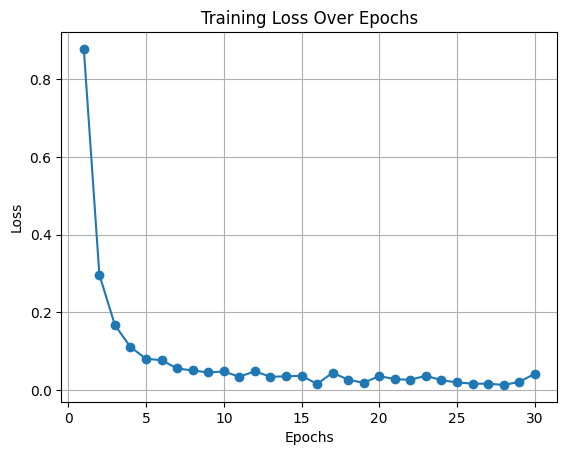

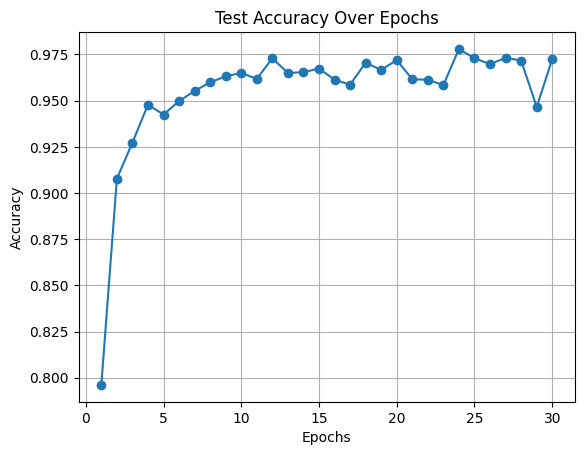

In [16]:
#loss curve
plt.plot(range(1, len(trainLosses) + 1), trainLosses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
#saves based on modality used
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "trainLoss_RGB.png"))
else:
    plt.savefig(os.path.join(saveResults, "trainLoss_Thermal.png"))
plt.show()

#accuracy
plt.plot(range(1, len(testAccuracies) + 1), testAccuracies, marker='o')
plt.title("Test Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
#saves based on modality used
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "testAccuracy_RGB.png"))
else:
    plt.savefig(os.path.join(saveResults, "testAccuracy_Thermal.png"))
plt.show()


Classification Report:
              precision    recall  f1-score   support

       Angry       0.96      0.98      0.97       780
     Disgust       0.99      0.97      0.98       221
        Fear       0.99      0.94      0.97       346
       Happy       0.99      0.95      0.97      1206
     Neutral       0.94      0.99      0.96       103
         Sad       0.98      1.00      0.99       883
   Surprised       0.93      0.98      0.96       600

    accuracy                           0.97      4139
   macro avg       0.97      0.97      0.97      4139
weighted avg       0.97      0.97      0.97      4139



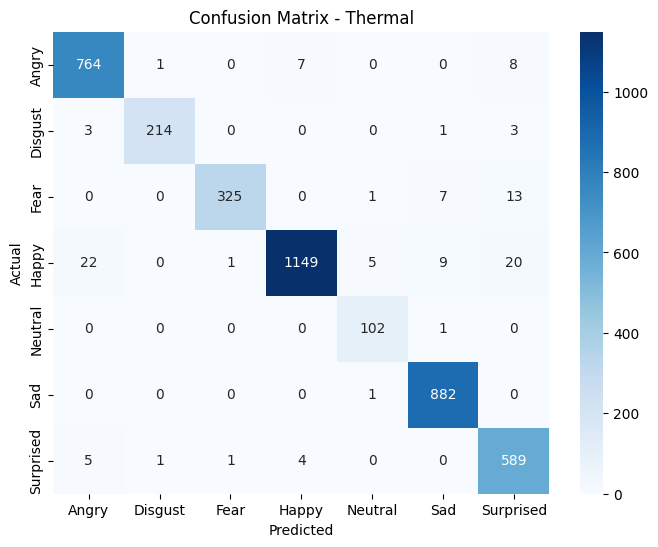

In [17]:
# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(targetsArr, predictionsArr)
report = classification_report(targetsArr, predictionsArr, target_names=classNames)

print("\nClassification Report:")
print(report)

# Save classification report
if savingLabel == "RGB":
    with open(os.path.join(saveResults, "classificationReport_RGB.txt"), "w") as f:
        f.write(report)
elif savingLabel == "Thermal":
    with open(os.path.join(saveResults, "classificationReport_Thermal.txt"), "w") as f:
        f.write(report)
else:
    with open(os.path.join(saveResults, "classificationReport_MultiModal_EarlyFusion.txt"), "w") as f:
        f.write(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt="d",
            xticklabels=classNames,
            yticklabels=classNames,
            cmap="Blues")

plt.title(f"Confusion Matrix - {savingLabel}")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Save confusion matrix
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "confusionMatrix_RGB.png"), bbox_inches="tight")
elif savingLabel == "Thermal":
    plt.savefig(os.path.join(saveResults, "confusionMatrix_Thermal.png"), bbox_inches="tight")
else:
    plt.savefig(os.path.join(saveResults, "confusionMatrix_MultiModal_EarlyFusion.png"), bbox_inches="tight")

plt.show()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


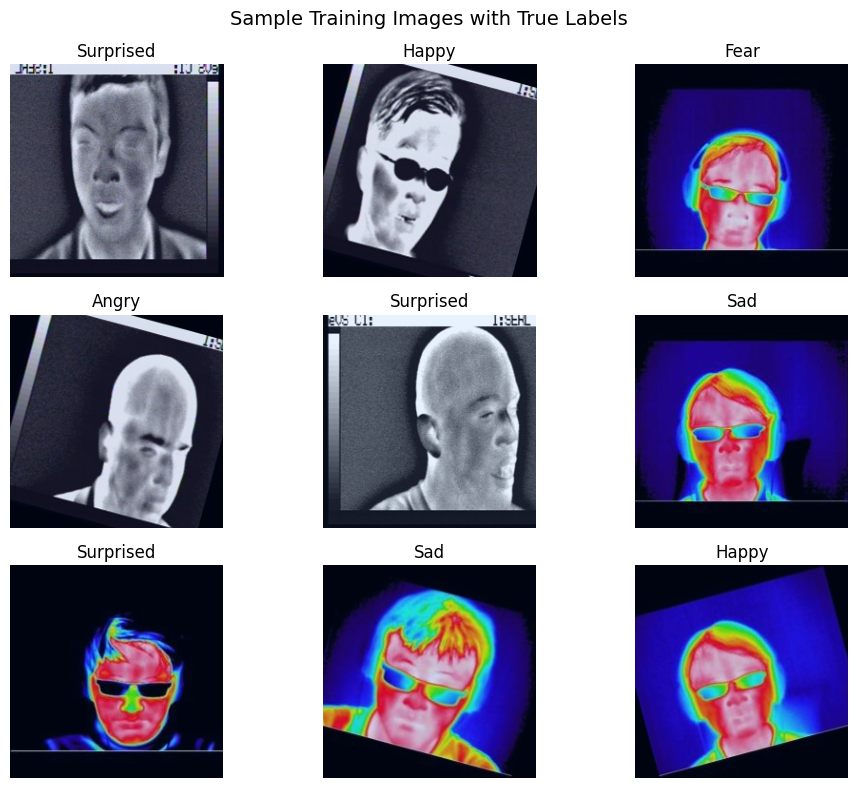

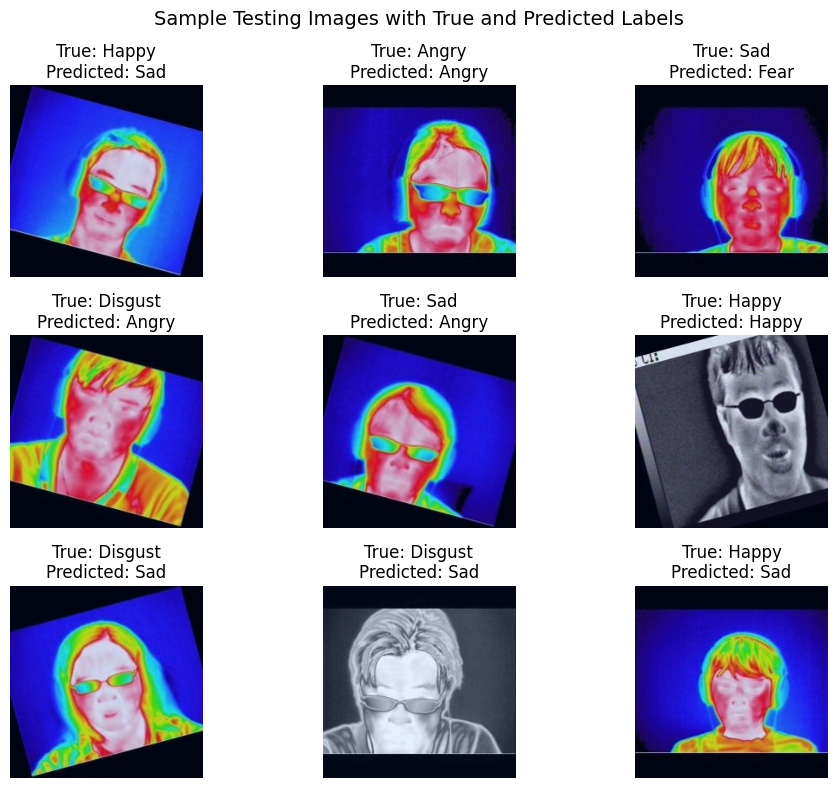

In [18]:
#visualising some images and their labels

#true images and labels
imagesPlot, labelsPlot = next(iter(train_loader))

fig = plt.figure(figsize=(10, 8))
for i in range(3*3):

    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(np.transpose(torchvision.utils.make_grid(imagesPlot[i].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))
    ax.set_title(classNames[labelsPlot[i]])
    ax.axis('off')
    plt.suptitle('Sample Training Images with True Labels',fontsize=14)
plt.tight_layout()


#predicted images and labels
imagesPlotPred, labelsPlotPred = next(iter(test_loader))

fig = plt.figure(figsize=(10, 8))
for i in range(3*3):

    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(np.transpose(torchvision.utils.make_grid(imagesPlotPred[i].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))

    trueLabel = classNames[labelsPlotPred[i]]
    predictedLabel = classNames[predicted[i]]

    ax.set_title(f'True: {trueLabel}\nPredicted: {predictedLabel}')
    ax.axis("off")
    plt.suptitle('Sample Testing Images with True and Predicted Labels',fontsize=14)
plt.tight_layout()